In [81]:
%load_ext dotenv
%dotenv

import numpy as np
import networkx as nx
from neo4j import GraphDatabase
import os
import matplotlib.pyplot as plt
import dspy
import itertools

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [3]:
db_url = os.getenv("DB_HOST", "neo4j://localhost:7687")
db_user = os.getenv("DB_USER", "neo4j")
db_pass = os.getenv("DB_PASSWORD", "no_password")
db_base = os.getenv("DB_DATABASE", "neo4j")
label_model = os.getenv("LABEL_MODEL", "openai/gpt-4o-mini")

export_temp = "/tmp/communities_neo4j_export.graphml"

if not os.path.isfile(export_temp):
	print("Connecting to db")
	with GraphDatabase.driver(db_url, auth=(db_user, db_pass)) as driver:
		driver.verify_connectivity()

		print("Fetching database as graphml")
		records, _, _ = driver.execute_query("""
			CALL apoc.export.graphml.all(null, {stream:true})
			YIELD file, nodes, relationships, properties, data
			RETURN file, nodes, relationships, properties, data
		""")
		_, n_nodes, n_relationships, _, export_contents = records[0]
		print(f"Downloaded {n_nodes} nodes, {n_relationships} relationships")

		print("Saving as temporary file")
		with open(export_temp, "w") as f:
			f.write(export_contents)

print("Loading databse from file")
graph = nx.read_graphml(export_temp)


Loading databse from file


/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id id. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id louv_community. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id sources. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/

In [4]:
communities = nx.community.louvain_communities(graph)
print(f"Found {len(communities)} communities")

communities.sort(key=lambda v: len(v), reverse=True)

k = 20
print(f"First {k} have populations {[len(c) for c in communities[:k]]}")

Found 1935 communities
First 20 have populations [175, 113, 109, 102, 101, 92, 90, 87, 78, 69, 68, 68, 68, 65, 61, 53, 53, 46, 46, 29]


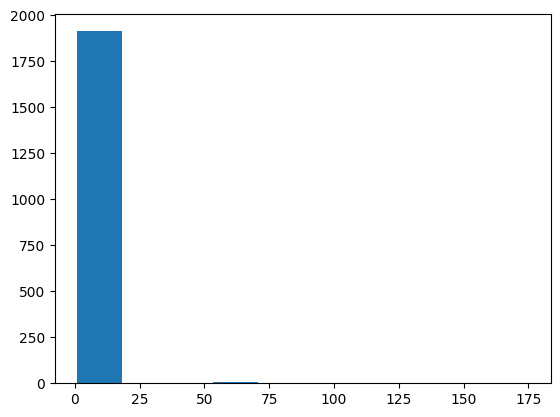

In [5]:
plt.hist([len(c) for c in communities])
plt.show()

# Seems that we get a lot of communities with very few members

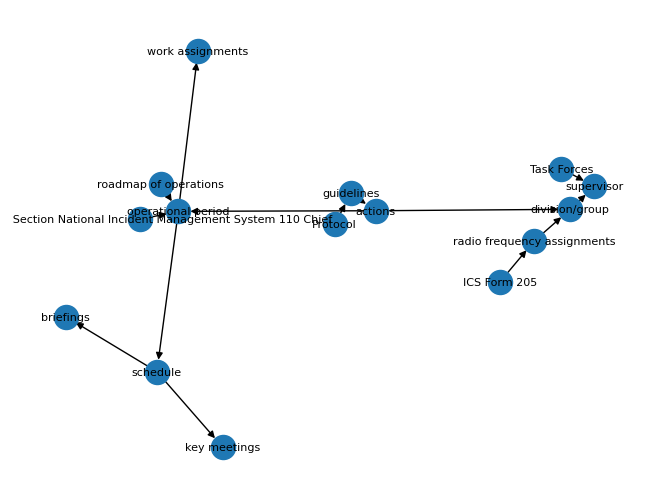

In [ ]:
def draw_subgraph(subgraph, **kwargs):
	nx.draw_spring(subgraph, labels=dict(subgraph.nodes(data="id")), font_size=8, **kwargs)

draw_subgraph(graph.subgraph(communities[22]))

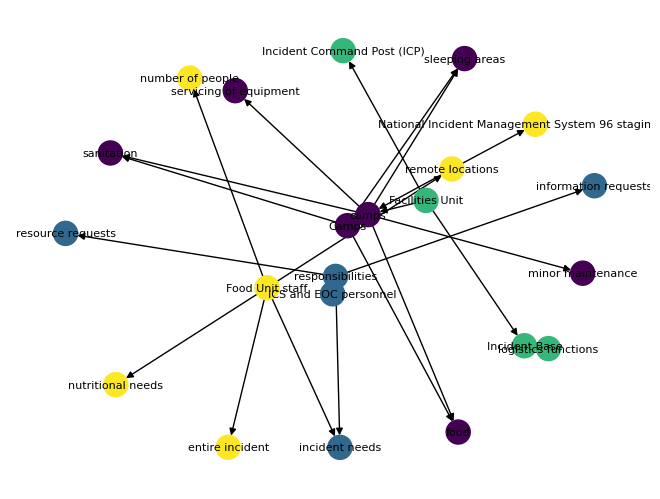

In [7]:
def draw_subgraph_communities(subgraph, communities):
	colours = []
	for node in subgraph:
		i = [i for i, c in enumerate(new_communities) if node in c][0]
		colours.append(i)
	draw_subgraph(subgraph, node_color=colours)

subgraph = graph.subgraph(communities[21])
new_communities = nx.community.louvain_communities(subgraph)

draw_subgraph_communities(subgraph, communities)

In [40]:

lm = dspy.LM(label_model)
dspy.configure(lm=lm)

class CommunityLabelSignature(dspy.Signature):
	"""
	Given a collection of entities, find a few words to label them.
	"""
	entities: list[str] = dspy.InputField()
	# context: str = dspy.InputField() # This bleeds into its answers
	label: str = dspy.OutputField()	

_label_community_p = dspy.Predict(CommunityLabelSignature)

def label_entities(entities):
	return _label_community_p(entities=entities).label

def label_community(graph, community):
	return label_entities([l for n, l in graph.subgraph(community).nodes(data="id")])

def label_community_demo(graph, community):
	entities = [l for n, l in graph.subgraph(community).nodes(data="id")]
	print(f"Graph with contents")
	for e in entities:
		print("\t", e)
	label = label_community(graph, community)
	print(f"is labeled as '{label}'")

label_community_demo(graph, communities[28])

Graph with contents
	 Logistics Section Personnel
	 Cooking Facilities
	 Transportation
	 Food Security and Safety
	 Supplies
	 Facilities
	 Food and Water Needs
	 Incident Traffic Plans
	 Vehicle Usage Records
	 Food Service Areas
	 Ground Transportation
	 Food Services
is labeled as 'Logistics and Food Services'


In [ ]:
# Recursively splits communities with at least `threshold` members 
# Retuns list of (this) or node id
def recursive_louvain(graph, threshold=10):
	communities = nx.community.louvain_communities(graph)
	result = []
	for community in communities:
		if len(community) >= threshold:
			# Recurse
			subgraph = graph.subgraph(community)
			result.append(recursive_louvain(subgraph, threshold=threshold))
		else:
			# Terminal community
			result.append(community)
	return result

print(recursive_louvain(graph.subgraph(communities[20]), threshold=5))

[[{'n2700'}, {'n1349'}, {'n3435'}, {'n1979'}, {'n1438'}, {'n3159'}], {'n525', 'n2680', 'n4093'}, [{'n79', 'n2009'}, {'n1112', 'n2221', 'n2619'}], {'n50', 'n240', 'n3269', 'n588'}, [{'n2366', 'n1942'}, {'n1916', 'n1444', 'n1527', 'n1220'}, {'n1992', 'n2021'}]]


In [ ]:
# turn louvain communities into labels bottom-up
def recursive_labels(graph, communities):
	if isinstance(communities, list):
		inner = [recursive_labels(graph, c) for c in communities]
		labels, _ = zip(*inner)
		# print(f"Make label for {labels}")
		return (label_entities(labels), inner)
	else:
		# Temrinal is a set
		# print(f"Make terminal label for {communities}")
		return (label_community(graph, list(communities)), [])

g = recursive_louvain(graph.subgraph(communities[20]), threshold=5)
print(recursive_labels(graph, g))

('Information Management and Security', [('"Interdisciplinary Issues"', [('public interest topics', []), ('"Legal Complexity"', []), ('"Technology"', []), ('Resource Allocation', []), ('"Communication Systems"', []), ('cause of incident', [])]), ('Data Handling and Documentation', [('Data Management', []), ('"Documentation Process"', [])]), ('Information Management Framework', [('Information Management Methods', []), ('Measurement and Planning Tools', []), ('Information Management Concepts', [])]), ('Communication Technologies', []), ('Infrastructure Security', [])])


In [ ]:

def communities_labels_graph_recursive(labels):
	g = nx.Graph()

	def dfs_node_addition(graph, labels, parent):
		root, children = labels
		graph.add_node(root)
		if parent:
			graph.add_edge(parent, root)
			# print(f"{parent} -> {root}")
		
		for label in children:
			dfs_node_addition(graph, label, root)

	dfs_node_addition(
		g,
		labels,
		None,
	)

	return g

def draw_circle_graph_thing(graph):
	pos = nx.nx_agraph.graphviz_layout(graph, prog="twopi", args="")
	plt.figure(figsize=(8, 8))
	nx.draw(graph, pos, node_size=20, alpha=0.75, node_color="blue", with_labels=True, font_size=10)
	plt.axis("equal")
	plt.show()

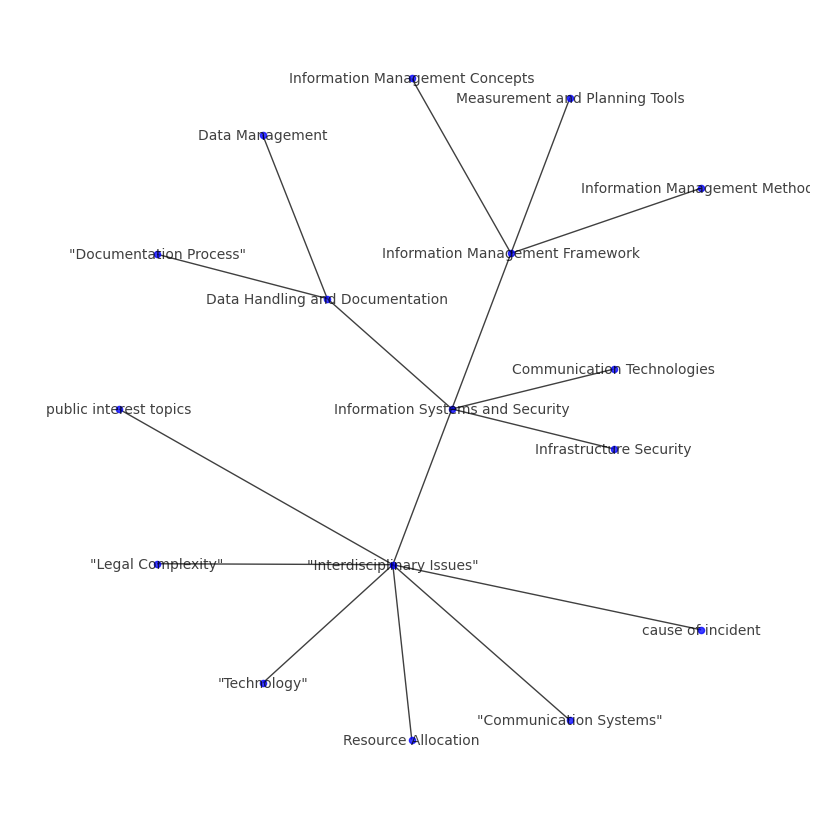

In [65]:
community = recursive_louvain(graph.subgraph(communities[20]), 5)
labels = recursive_labels(graph, community)

g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

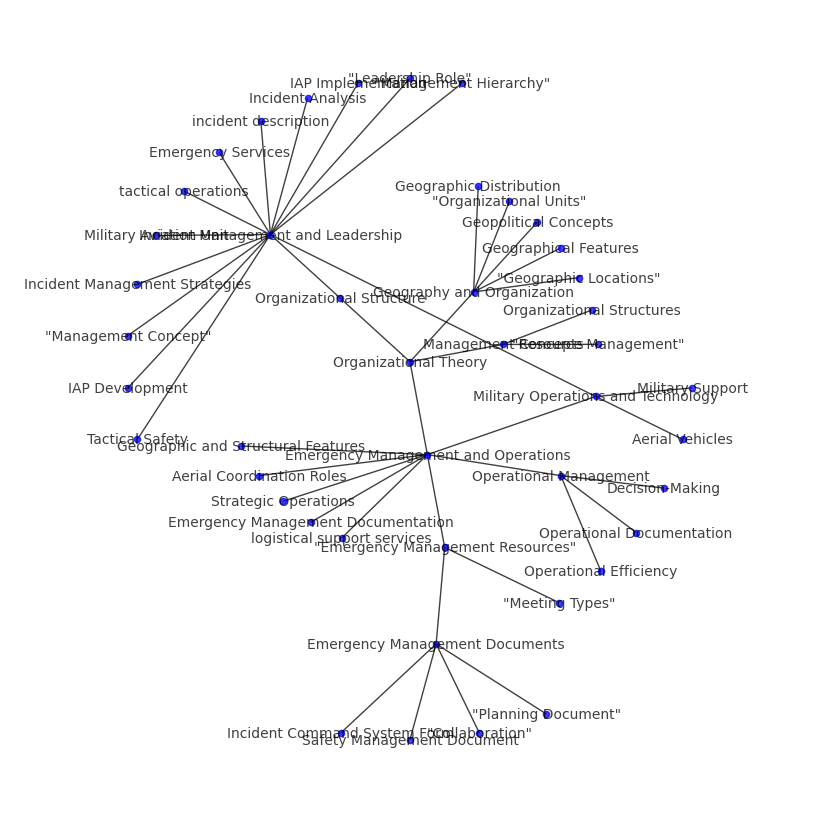

In [63]:
community = recursive_louvain(graph.subgraph(communities[10]), 5)
labels = recursive_labels(graph, community)

g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

In [68]:
print(f"That has {len(communities[10])} communities (plus their sub-communities)")
print(f"The full graph has {len(communities)} communities (plus their sub-communities!!!)")
print(f"I will not process that unless instructed to do so (expensive?)")

That has 68 communities (plus their sub-communities)
The full graph has 1935 communities (plus their sub-communities!!!)
I will not process that unless instructed to do so (expensive?)


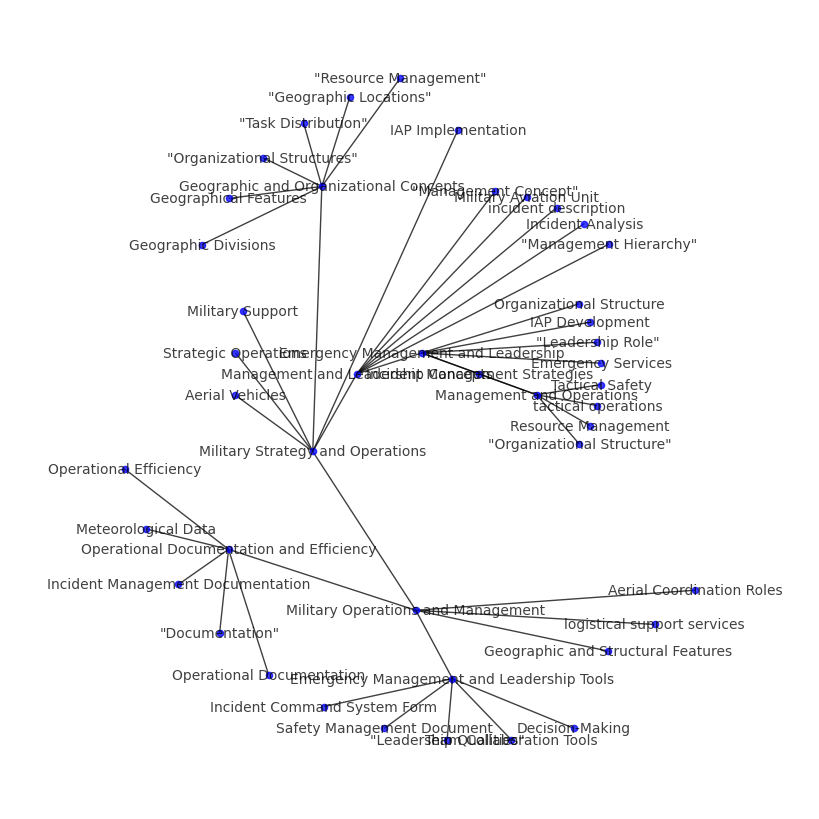

In [ ]:
def recursive_gn(graph, threshold=8, target=4):
	comp = nx.community.girvan_newman(graph)
	communities = next(itertools.islice(comp, target, None))
	result = []
	for community in communities:
		if len(community) >= threshold:
			subgraph = graph.subgraph(community)
			result.append(recursive_gn(subgraph, threshold=threshold, target=target))
		else:
			result.append(community)
	return result

community = recursive_gn(graph.subgraph(communities[10]))
labels = recursive_labels(graph, community)

g = communities_labels_graph_recursive(labels)
draw_circle_graph_thing(g)

# Interesting that it now interprets this cluster as being militaristic 